### Custom Predictor
Given 5 years of data, predict 3 months of sales data for each item and store.

- Referenced from notebook by [XYZT](https://www.kaggle.com/thexyzt/keeping-it-simple-by-xyzt)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path

root_path = '../input/demand-forecasting-kernels-only/'
train_original = pd.read_csv(Path(root_path, 'train.csv'), low_memory=False, 
                    parse_dates=['date'], index_col=['date'])
test_original = pd.read_csv(Path(root_path, 'test.csv'), low_memory=False, 
                   parse_dates=['date'], index_col=['date'])
sample_sub_original = pd.read_csv(Path(root_path, 'sample_submission.csv'))

In [2]:
train_original.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [3]:
train_original.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [4]:
test_original.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


In [5]:
test_original.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45000 entries, 2018-01-01 to 2018-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      45000 non-null  int64
 1   store   45000 non-null  int64
 2   item    45000 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


Here we notice that our test file contains only the store and item

We add additional features on a copy to preserve the original DataFrames

In [6]:
train = train_original.copy()

train['day'] = train.index.day
train['month'] = train.index.month
train['year'] = train.index.year
train['dayofweek'] = train.index.dayofweek
train['dayofyear'] = train.index.dayofyear
train['weekofyear'] = pd.Int64Index(train.index.isocalendar().week)

train.head()

,store,item,sales,day,month,year,dayofweek,dayofyear,weekofyear
date,,,,,,,,,
2013-01-01,1,1,13,1,1,2013,1,1,1
2013-01-02,1,1,11,2,1,2013,2,2,1
2013-01-03,1,1,14,3,1,2013,3,3,1
2013-01-04,1,1,13,4,1,2013,4,4,1
2013-01-05,1,1,10,5,1,2013,5,5,1


In [7]:
train.tail()

,store,item,sales,day,month,year,dayofweek,dayofyear,weekofyear
date,,,,,,,,,
2017-12-27,10,50,63,27,12,2017,2,361,52
2017-12-28,10,50,59,28,12,2017,3,362,52
2017-12-29,10,50,74,29,12,2017,4,363,52
2017-12-30,10,50,62,30,12,2017,5,364,52
2017-12-31,10,50,82,31,12,2017,6,365,52


Data set seems simple enough. Let us do some EDA.

# General Information

### Train Dataset
   - 5 years from 1/1/2013 (Tuesday) to 31/12/2017 (Saturday)
   - 1826 Contiguous days of sales (no store closure) 
   - 10 stores
   - 50 unique items
   - 500 unique (store-item) pairs (This means every store sells those 50 items)

In [8]:
# number of years
print(train.year.unique())

# number of months
print(train.month.unique())

# number of days - 
print(train.day.unique())

# number of stores
print(train.store.unique())

# number of items
print(train.item.unique())

[2013 2014 2015 2016 2017]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


In [9]:
counts = train.groupby(['store','item']).size().reset_index().rename(columns={0:'count'})['count']
counts.unique()

array([1826])

We can see that we have 1826 (5 years) contiguous data as all counts are of value 1826.

We also do not have any NaN or null values

In [10]:
for col in train.columns:
    print(train[col].isnull().all())

False
False
False
False
False
False
False
False
False


In [11]:
train

,store,item,sales,day,month,year,dayofweek,dayofyear,weekofyear
date,,,,,,,,,
2013-01-01,1,1,13,1,1,2013,1,1,1
2013-01-02,1,1,11,2,1,2013,2,2,1
2013-01-03,1,1,14,3,1,2013,3,3,1
2013-01-04,1,1,13,4,1,2013,4,4,1
2013-01-05,1,1,10,5,1,2013,5,5,1
...,...,...,...,...,...,...,...,...,...
2017-12-27,10,50,63,27,12,2017,2,361,52
2017-12-28,10,50,59,28,12,2017,3,362,52
2017-12-29,10,50,74,29,12,2017,4,363,52


# Exploratory Data Analysis

### Seasonality
Every year, the mean sales follow a pattern, displaying a seasonality trend repeating every year, in an increasing fashion.
- Mean sales increase as the year increases from 2013 to 2017
- Mean sales trend increases from the start of the year (January) and peaks at the month of July before decreasing till December, with the exception of a subtle increase in mean sales between October and November.

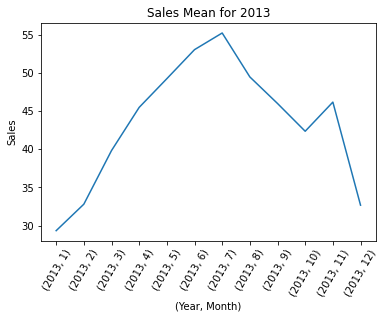

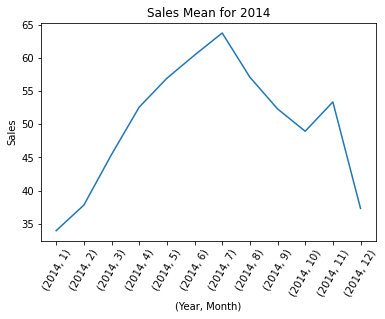

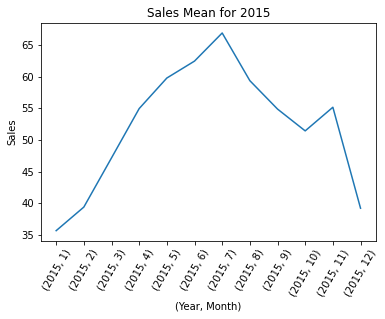

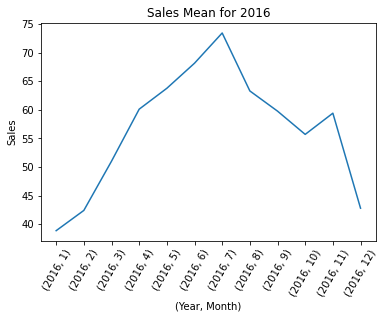

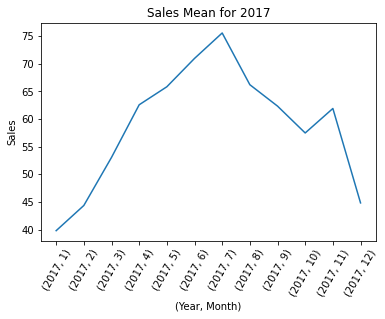

In [12]:
temp_df = train[['year', 'month', 'sales']]

for i in temp_df.year.unique():
    ax = temp_df[temp_df['year'] == i].groupby(['year', 'month']).mean().plot(xticks=range(temp_df.month.nunique()), legend=False)
    ax.set_xticklabels(labels=temp_df[temp_df['year'] == i].groupby(['year', 'month']).mean().index, rotation=60)
    ax.set_title(f'Sales Mean for {i}')
    ax.set_xlabel('(Year, Month)')
    ax.set_ylabel('Sales')

Plotting the sums instead of mean sales yields a similar seasonality trend.

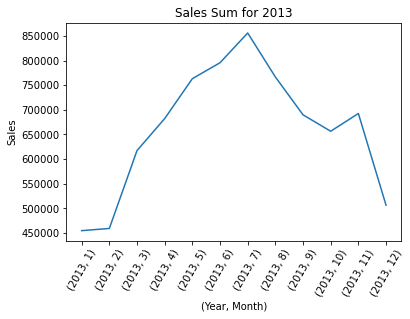

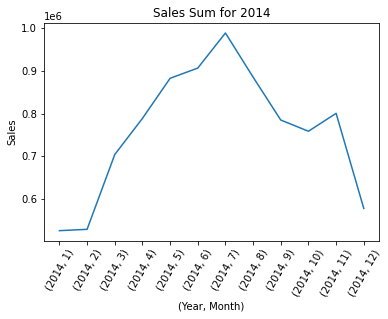

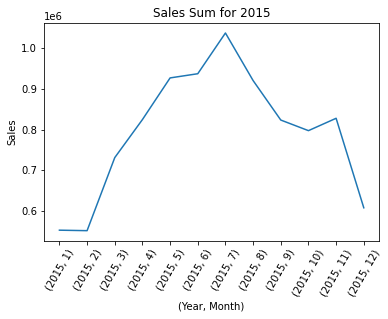

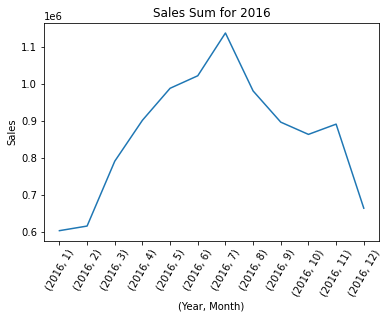

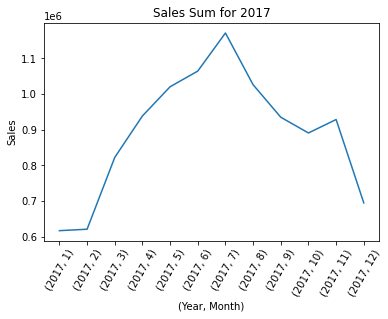

In [13]:
temp_df = train[['year', 'month', 'sales']]

for i in temp_df.year.unique():
    ax = temp_df[temp_df['year'] == i].groupby(['year', 'month']).sum().plot(xticks=range(temp_df.month.nunique()), legend=False)
    ax.set_xticklabels(labels=temp_df[temp_df['year'] == i].groupby(['year', 'month']).sum().index, rotation=60)
    ax.set_title(f'Sales Sum for {i}')
    ax.set_xlabel('(Year, Month)')
    ax.set_ylabel('Sales')

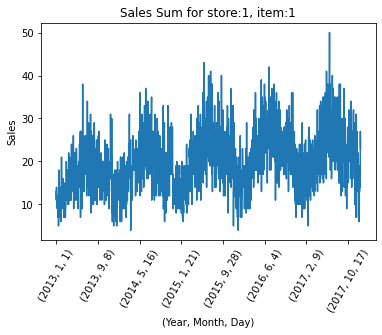

In [14]:
temp_df = train[['year', 'month', 'day', 'sales', 'store', 'item']]

for i in temp_df.store.unique():
    for j in temp_df.item.unique():
        temp_df_si = temp_df[(temp_df['store'] == i) & (temp_df['item'] == j)]
        ax = temp_df_si[['year', 'month', 'day', 'sales']].groupby(['year', 'month', 'day']).sum().plot(legend=False, rot=60)
        ax.set_title(f'Sales Sum for store:{i}, item:{j}')
        ax.set_xlabel('(Year, Month, Day)')
        ax.set_ylabel('Sales')
        break
    break

### Let us see how the mean sales changes over the years, for all items and stores

In [15]:
agg_year_item = pd.pivot_table(train, index='year', columns='item', values='sales', aggfunc=np.mean)
agg_year_store = pd.pivot_table(train, index='year', columns='store', values='sales', aggfunc=np.mean)

In [16]:
agg_year_item

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
year,,,,,,,,,,,,,,,,,,,,,
2013,18.280274,48.793425,30.523836,18.440822,15.238630,48.773151,48.876712,63.952055,42.823014,60.841370,...,18.283562,30.580274,42.785753,24.590137,67.050685,48.993151,18.298082,42.681918,24.293973,54.928767
2014,21.034795,56.112055,35.042192,21.104110,17.498356,56.087397,55.995068,73.784110,49.195616,70.114247,...,21.021644,35.188493,49.049315,28.174521,77.086301,56.138630,21.069589,49.272055,28.208219,63.214521
2015,22.056712,58.574795,36.761096,22.071233,18.326027,58.377808,58.613425,76.911233,51.626575,73.087671,...,22.075616,36.835068,51.231507,29.398630,80.620548,58.514795,21.986849,51.373973,29.498356,65.863836
2016,23.831694,63.508197,39.560383,23.831967,19.957104,63.516940,63.392623,83.260656,55.567486,79.375410,...,23.821311,39.702459,55.513934,31.803005,87.245628,63.639617,23.813388,55.516667,31.616667,71.432787
2017,24.699452,65.868767,41.315616,24.598082,20.769041,65.750411,65.764110,86.824932,57.725205,82.701644,...,24.803562,41.126027,57.879726,33.018082,90.899452,65.899452,24.843836,57.908219,33.053151,73.955890


In [17]:
agg_year_store

store,1,2,3,4,5,6,7,8,9,10
year,,,,,,,,,,
2013,39.333699,55.903452,49.530740,45.756658,33.084000,33.116329,30.258795,53.405753,45.796603,48.950575
2014,45.303342,64.208055,57.014795,52.559178,38.115014,38.093918,34.848110,61.473808,52.700219,56.257918
2015,47.216986,66.968986,59.512493,54.944110,39.744767,39.776274,36.398192,64.166904,55.124438,58.716000
2016,51.229126,72.651530,64.514699,59.464208,43.129563,42.967158,39.365137,69.436885,59.608251,63.598470
2017,53.247890,75.418411,67.066630,61.778082,44.768274,44.705041,40.940219,72.212384,62.003123,66.010082


- `agg_year_item` show the mean sales of an item across all stores
- `agg_year_store` show the mean sales of a store, for all items

We can plot them relative to their item/store averages and obtain Relative Sales vs. Year plots showing their trend across the years.

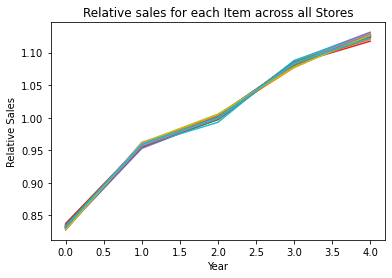

In [18]:
plt.plot(agg_year_item.values / agg_year_item.values.mean(axis=0))
plt.title("Relative sales for each Item across all Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()

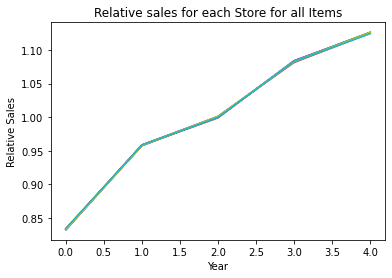

In [19]:
plt.plot(agg_year_store.values / agg_year_store.values.mean(axis=0))
plt.title("Relative sales for each Store for all Items")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()

Doing the same for months instead of years, we can see the the monthly trends for every year

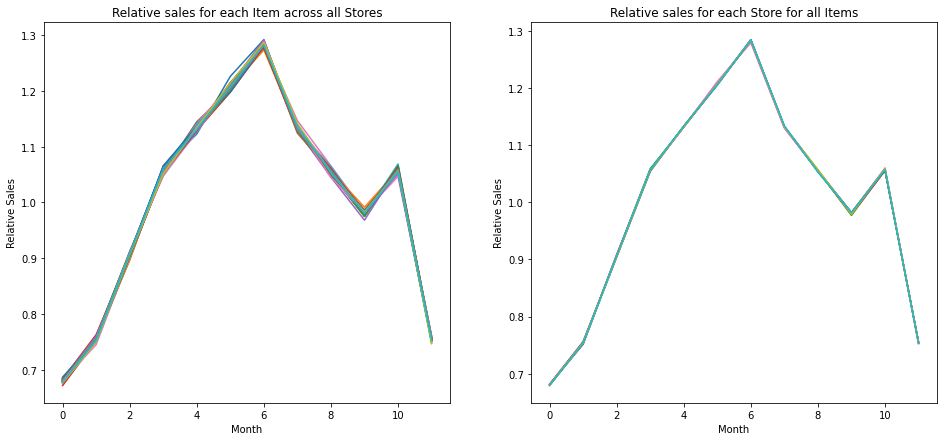

In [20]:
agg_month_item = pd.pivot_table(train, index='month', columns='item', values='sales', aggfunc=np.mean)
agg_month_store = pd.pivot_table(train, index='month', columns='store', values='sales', aggfunc=np.mean)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

axs[0].plot(agg_month_item.values / agg_month_item.values.mean(axis=0))
axs[0].set_title("Relative sales for each Item across all Stores")
axs[0].set_xlabel("Month")
axs[0].set_ylabel("Relative Sales")

axs[1].plot(agg_month_store.values / agg_month_store.values.mean(axis=0))
axs[1].set_title("Relative sales for each Store for all Items")
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Relative Sales")
plt.show()

We can do the same for the `day`, `dayofweek`, `dayofyear` and `weekofyear` columns.

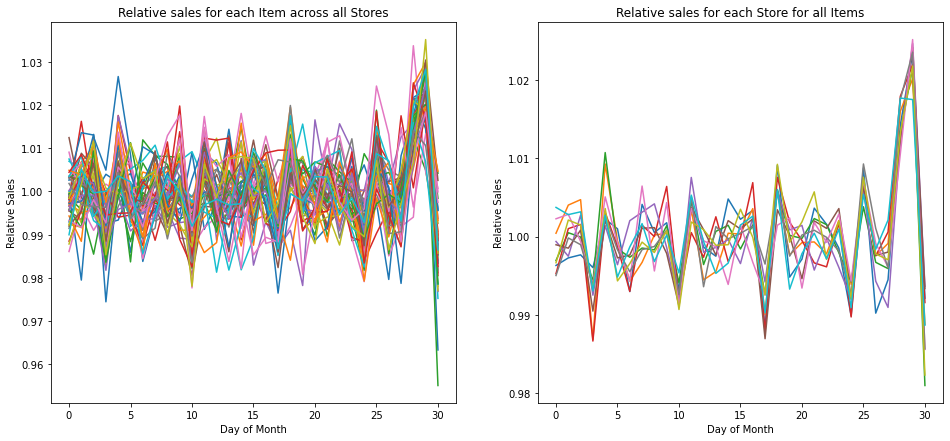

In [21]:
agg_day_item = pd.pivot_table(train, index='day', columns='item', values='sales', aggfunc=np.mean)
agg_day_store = pd.pivot_table(train, index='day', columns='store', values='sales', aggfunc=np.mean)


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

axs[0].plot(agg_day_item.values / agg_day_item.values.mean(axis=0))
axs[0].set_title("Relative sales for each Item across all Stores")
axs[0].set_xlabel("Day of Month")
axs[0].set_ylabel("Relative Sales")

axs[1].plot(agg_day_store.values / agg_day_store.values.mean(axis=0))
axs[1].set_title("Relative sales for each Store for all Items")
axs[1].set_xlabel("Day of Month")
axs[1].set_ylabel("Relative Sales")
plt.show()

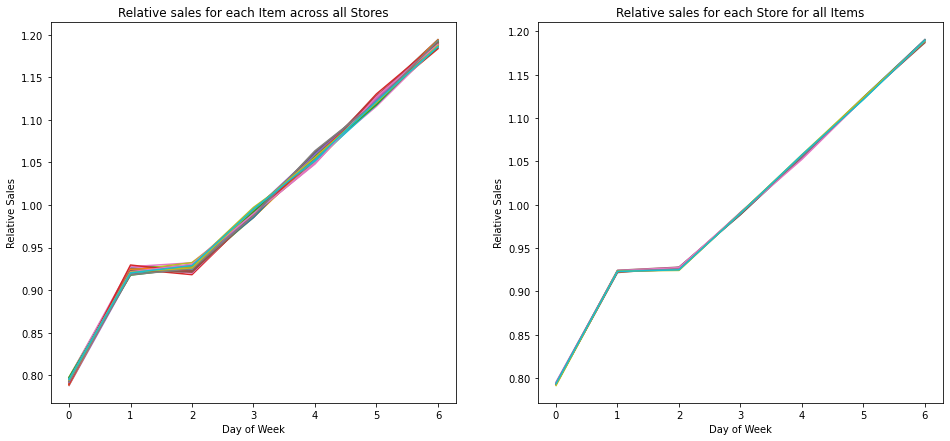

In [22]:
agg_dow_item = pd.pivot_table(train, index='dayofweek', columns='item', values='sales', aggfunc=np.mean)
agg_dow_store = pd.pivot_table(train, index='dayofweek', columns='store', values='sales', aggfunc=np.mean)


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

axs[0].plot(agg_dow_item.values / agg_dow_item.values.mean(axis=0))
axs[0].set_title("Relative sales for each Item across all Stores")
axs[0].set_xlabel("Day of Week")
axs[0].set_ylabel("Relative Sales")

axs[1].plot(agg_dow_store.values / agg_dow_store.values.mean(axis=0))
axs[1].set_title("Relative sales for each Store for all Items")
axs[1].set_xlabel("Day of Week")
axs[1].set_ylabel("Relative Sales")
plt.show()

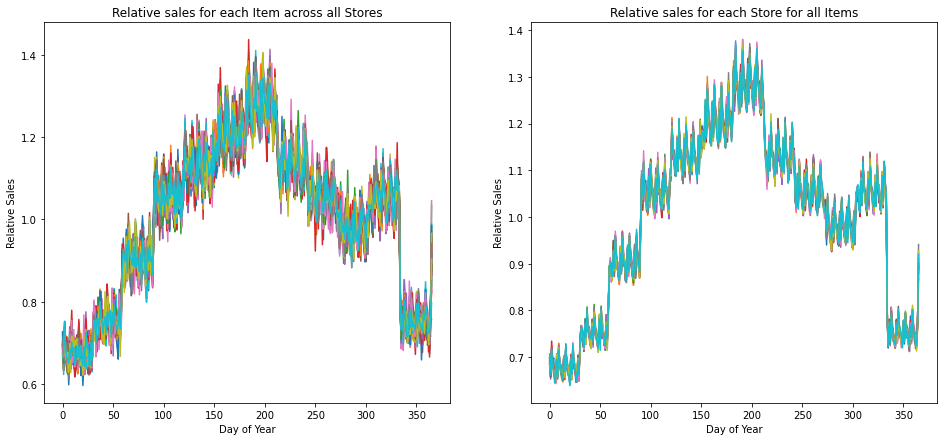

In [23]:
agg_doy_item = pd.pivot_table(train, index='dayofyear', columns='item', values='sales', aggfunc=np.mean)
agg_doy_store = pd.pivot_table(train, index='dayofyear', columns='store', values='sales', aggfunc=np.mean)


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

axs[0].plot(agg_doy_item.values / agg_doy_item.values.mean(axis=0))
axs[0].set_title("Relative sales for each Item across all Stores")
axs[0].set_xlabel("Day of Year")
axs[0].set_ylabel("Relative Sales")

axs[1].plot(agg_doy_store.values / agg_doy_store.values.mean(axis=0))
axs[1].set_title("Relative sales for each Store for all Items")
axs[1].set_xlabel("Day of Year")
axs[1].set_ylabel("Relative Sales")
plt.show()

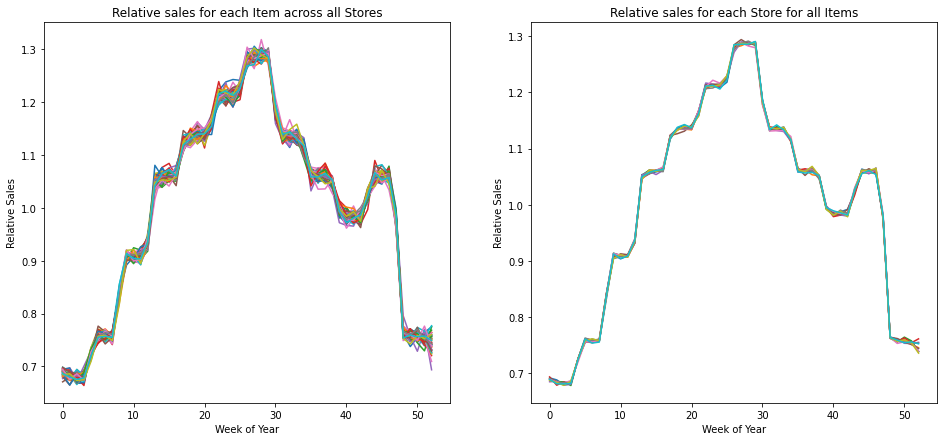

In [24]:
agg_woy_item = pd.pivot_table(train, index='weekofyear', columns='item', values='sales', aggfunc=np.mean)
agg_woy_store = pd.pivot_table(train, index='weekofyear', columns='store', values='sales', aggfunc=np.mean)


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

axs[0].plot(agg_woy_item.values / agg_woy_item.values.mean(axis=0))
axs[0].set_title("Relative sales for each Item across all Stores")
axs[0].set_xlabel("Week of Year")
axs[0].set_ylabel("Relative Sales")

axs[1].plot(agg_woy_store.values / agg_woy_store.values.mean(axis=0))
axs[1].set_title("Relative sales for each Store for all Items")
axs[1].set_xlabel("Week of Year")
axs[1].set_ylabel("Relative Sales")
plt.show()

### Observations
- Overall, we can notice items and stores mean sales share common increasing patterns across the years
- We notice the monthly seasonality applies to relative sales, just like the sales sum plot across the years that was shown earlier
- The sales for all stores and items share the same trend over days of the week as well

### Possible Pattern Degeneracies
It is possible that our patterns do not hold for specific cases; e.g. when looking at patterns across days of the week (`dayofweek` column), the pattern we find might across the items and stores might not hold across months or years. 

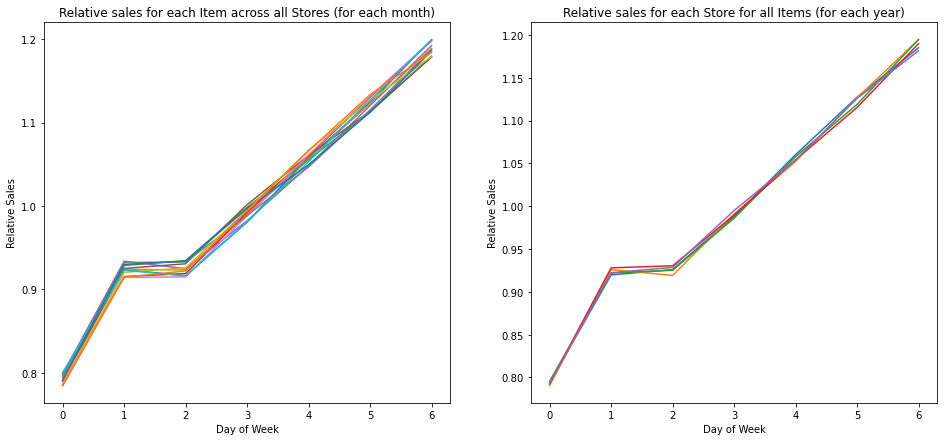

In [25]:
agg_dow_month = pd.pivot_table(train, index='dayofweek', columns='month', values='sales', aggfunc=np.mean)
agg_dow_year = pd.pivot_table(train, index='dayofweek', columns='year', values='sales', aggfunc=np.mean)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

axs[0].plot(agg_dow_month.values / agg_dow_month.values.mean(axis=0))
axs[0].set_title("Relative sales for each Item across all Stores (for each month)")
axs[0].set_xlabel("Day of Week")
axs[0].set_ylabel("Relative Sales")

axs[1].plot(agg_dow_year.values / agg_dow_year.values.mean(axis=0))
axs[1].set_title("Relative sales for each Store for all Items (for each year)")
axs[1].set_xlabel("Day of Week")
axs[1].set_ylabel("Relative Sales")
plt.show()

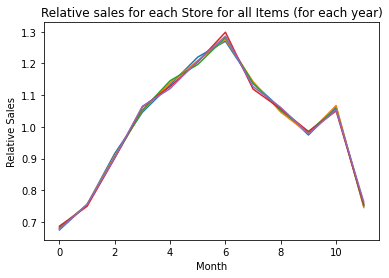

In [26]:
agg_month_year = pd.pivot_table(train, index='month', columns='year', values='sales', aggfunc=np.mean)

plt.plot(agg_month_year.values / agg_month_year.values.mean(axis=0))
plt.title("Relative sales for each Store for all Items (for each year)")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.show()

There do not seem to be any cases where our patterns do not hold across multiple features. Hence, we assume each column as features independent of one another.

# Define a Model
We define a model that consists of look up tables.

- Each look up table represents a feature that we use in the model.
- We divide all the sales values in the tables we define by the mean sales, as a means to allow the features we choose to have weight on the prediction outcome.

For this model, we define our prediction to be the average sales for a particular item for that particular day of the week, multiplied by the relative sales for the features selected and the relative sales predicted by the year via `np.polyfit()`
- The yearly relative sales are predicted as per our task of predicting the future 3 months sales

In [27]:
test = test_original.copy()

test['day'] = test.index.day
test['month'] = test.index.month
test['year'] = test.index.year
test['dayofweek'] = test.index.dayofweek
test['dayofyear'] = test.index.dayofyear
test['weekofyear'] = pd.Int64Index(test.index.isocalendar().week)

test.head()

,id,store,item,day,month,year,dayofweek,dayofyear,weekofyear
date,,,,,,,,,
2018-01-01,0,1,1,1,1,2018,0,1,1
2018-01-02,1,1,1,2,1,2018,1,2,1
2018-01-03,2,1,1,3,1,2018,2,3,1
2018-01-04,3,1,1,4,1,2018,3,4,1
2018-01-05,4,1,1,5,1,2018,4,5,1


### Predictor 1

In [28]:
mean_sales = train.sales.mean()

# Base sales look up table
dow_item_table = pd.pivot_table(train, index='dayofweek', columns='item', values='sales', aggfunc=np.mean)

# Feature tables
month_table = pd.pivot_table(train, index='month', values='sales', aggfunc=np.mean)
month_table.sales /= mean_sales

dow_table = pd.pivot_table(train, index='dayofweek', values='sales', aggfunc=np.mean)
dow_table.sales /= mean_sales

# Predictor table used in the polyfit function
year_table = pd.pivot_table(train, index='year', values='sales', aggfunc=np.mean)
year_table.sales /= mean_sales

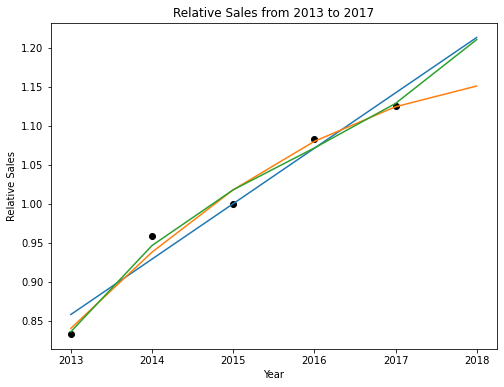

In [29]:
years = [2013, 2014, 2015, 2016, 2017, 2018]

p1 = np.poly1d(np.polyfit(years[:-1], year_table.values.squeeze(), 1))
p2 = np.poly1d(np.polyfit(years[:-1], year_table.values.squeeze(), 2))
p3 = np.poly1d(np.polyfit(years[:-1], year_table.values.squeeze(), 3))

plt.figure(figsize=(8, 6))
plt.plot(years[:-1], year_table.values.squeeze(), 'ko')
plt.plot(years, p1(years), 'C0-')
plt.plot(years, p2(years), 'C1-')
plt.plot(years, p3(years), 'C2-')

plt.title("Relative Sales from 2013 to 2017")
plt.ylabel("Relative Sales")
plt.xlabel("Year")
plt.show()

In [30]:
print(f'p1 prediction for 2018: {p1(2018)}')
print(f'p2 prediction for 2018: {p2(2018)}')
print(f'p3 prediction for 2018: {p3(2018)}')

p1 prediction for 2018: 1.2132074548927676
p2 prediction for 2018: 1.1509071219697944
p3 prediction for 2018: 1.2104763090610504


We note that a quadratic regressor works better to capture the slowing growth across the years; we should avoid p3 as it runs a higher risk of overfitting as we do not have many data points for the Year feature.

We define a function that prepares our predictions in the form of a `submission.csv`, by editing `sample_submission.csv`.

In [31]:
def predictor(test, submission):
    '''
    Adapted from the Keeping It simple Kaggle notebook by XYZT
    '''
    submission[['sales']] = submission[['sales']].astype(np.float64)
    for _, row in test.iterrows():
        dow, month, year = row.dayofweek, row.month, row.year
        item, store = row['item'], row['store']
        
        base_sales = dow_item_table.at[dow, item]
        
        mul = month_table.at[month, 'sales'] * dow_table.at[dow, 'sales']
        
        pred_sales = base_sales * mul * p2(year)
        
        submission.at[row['id'], 'sales'] = pred_sales
        
    return submission

In [32]:
predictions = predictor(test.copy(), sample_sub_original.copy())
predictions['sales'] = np.round(predictions['sales']).astype(int)
predictions

,id,sales
0,0,11
1,1,15
2,2,15
3,3,17
4,4,19
...,...,...
44995,44995,58
44996,44996,59
44997,44997,68
44998,44998,76


In [33]:
predictions.to_csv('./submission.csv', index=False) # Public Score of 24.4

### Predictor 2
Try a store-item look up table for the base values instead of a dow-item table (as per https://www.kaggle.com/thexyzt/keeping-it-simple-by-xyzt, and we consider adding in more features)

In [34]:
mean_sales = train.sales.mean()

# Base sales look up table
store_item_table = pd.pivot_table(train, index='store', columns='item', values='sales', aggfunc=np.mean)

# Feature tables
month_table = pd.pivot_table(train, index='month', values='sales', aggfunc=np.mean)
month_table.sales /= mean_sales

dow_table = pd.pivot_table(train, index='dayofweek', values='sales', aggfunc=np.mean)
dow_table.sales /= mean_sales

doy_table = pd.pivot_table(train, index='dayofyear', values='sales', aggfunc=np.mean)
doy_table.sales /= mean_sales

woy_table = pd.pivot_table(train, index='weekofyear', values='sales', aggfunc=np.mean)
woy_table.sales /= mean_sales

# Predictor table used in the polyfit function
year_table = pd.pivot_table(train, index='year', values='sales', aggfunc=np.mean)
year_table.sales /= mean_sales

def predictor2(test, submission):
    '''
    Adapted from the Keeping It simple Kaggle notebook by XYZT
    '''
    submission[['sales']] = submission[['sales']].astype(np.float64)
    for _, row in test.iterrows():
        dow, month, year = row.dayofweek, row.month, row.year
        doy, woy = row.dayofyear, row.weekofyear
        
        item, store = row['item'], row['store']
        
        base_sales = store_item_table.at[store, item]
        
        mul = month_table.at[month, 'sales'] * dow_table.at[dow, 'sales'] * doy_table.at[doy, 'sales']
        
        pred_sales = base_sales * mul * p2(year)
        
        submission.at[row['id'], 'sales'] = pred_sales
        
    return submission

predictions = predictor2(test.copy(), sample_sub_original.copy())
predictions['sales'] = np.round(predictions['sales']).astype(int)
predictions

,id,sales
0,0,9
1,1,10
2,2,10
3,3,11
4,4,11
...,...,...
44995,44995,63
44996,44996,68
44997,44997,70
44998,44998,74


In [35]:
predictions.to_csv('./submission.csv', index=False) # Public Score of 38.2??? OOF.

Through similar testing with additional features, we find that our Public score of the `submission.csv` file decreases.
- For a predictor using: 
    - Month, Day of Year; Public Score: 37.1
    - Month, Day of Week, Day of Year; Public Score: 38.2
    - Month, Day of Week, Public Score: 13.9 (as per https://www.kaggle.com/thexyzt/keeping-it-simple-by-xyzt)
    
The lower scores might be expected as we have noticed prior that in the plots of agg plots of the features `dayofyear` and `weekofyear` are quite noisy across all the stores and items. Hence likewise, the feature `day` would probably yield a similar drop in Public Score.

### Predictor 3
Now, we tweak the p2 regressor to give more weight to recent data. This can be done by an exponential decay function.

In [36]:
years = np.arange(2013, 2019)

weights = np.exp((years - 2018)/7)

print(weights)

p2_weights = np.poly1d(np.polyfit(years[:-1], year_table.values.squeeze(), 2, w=weights[:-1]))

[0.48954166 0.56471812 0.65143906 0.75147729 0.8668779  1.        ]


As we can see, the weightage of data dating further back from 2018 decreases rapidly.

In [37]:
mean_sales = train.sales.mean()

# Base sales look up table
store_item_table = pd.pivot_table(train, index='store', columns='item', values='sales', aggfunc=np.mean)

# Feature tables
month_table = pd.pivot_table(train, index='month', values='sales', aggfunc=np.mean)
month_table.sales /= mean_sales

dow_table = pd.pivot_table(train, index='dayofweek', values='sales', aggfunc=np.mean)
dow_table.sales /= mean_sales

# Predictor table used in the polyfit function
year_table = pd.pivot_table(train, index='year', values='sales', aggfunc=np.mean)
year_table.sales /= mean_sales

def predictor3(test, submission):
    '''
    Adapted from the Keeping It simple Kaggle notebook by XYZT
    '''
    submission[['sales']] = submission[['sales']].astype(np.float64)
    for _, row in test.iterrows():
        dow, month, year = row.dayofweek, row.month, row.year
        
        item, store = row['item'], row['store']
        
        base_sales = store_item_table.at[store, item]
        
        mul = month_table.at[month, 'sales'] * dow_table.at[dow, 'sales']
        
        pred_sales = base_sales * mul * p2_weights(year)
        
        submission.at[row['id'], 'sales'] = pred_sales
        
    return submission

predictions = predictor3(test.copy(), sample_sub_original.copy())
predictions['sales'] = np.round(predictions['sales']).astype(int)
predictions

,id,sales
0,0,12
1,1,14
2,2,15
3,3,16
4,4,17
...,...,...
44995,44995,72
44996,44996,72
44997,44997,77
44998,44998,82


In [38]:
predictions.to_csv('./submission.csv', index=False) # Public Score of 13.85